In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [2]:
%load_ext autoreload
%autoreload 2

import pickle
import time
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm 

from spectral_adversarial_regularization.models import elunet as model
from spectral_adversarial_regularization import adversarial as ad
from spectral_adversarial_regularization import dl_utils

%matplotlib inline

In [3]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("MNIST_data/", one_hot=False)

Xtr = mnist.train.images.reshape(-1, 28, 28, 1)
Ytr = mnist.train.labels.astype(float)

Xtt = mnist.test.images.reshape(-1, 28, 28, 1)
Ytt = mnist.test.labels.astype(float)

num_classes = 10
val_set = {'X': Xtt[:500], 'Y': Ytt[:500]}
C2 = np.mean([np.sqrt(np.sum(np.square(i))) for i in Xtr])
eps = 0.05*C2

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
def train_network(Xtr, Ytr, val_set, arch, save_dir, eps=0.3, adv=None,
                  gpu_prop=0.2, num_epochs=200, save_every=25, beta=1,
                  step_adv=None, adv_robustness=None, retrain=True):
    
    if retrain: os.system('rm -rf %s'%(save_dir))
        
    _ = dl_utils.build_graph_and_train(Xtr, Ytr, save_dir, arch,
                                       eps=eps,
                                       adv=adv,
                                       num_epochs=num_epochs,
                                       save_every=save_every,
                                       num_channels=1,
                                       batch_size=256,
                                       val_set=val_set,
                                       early_stop_acc=0.999,
                                       early_stop_acc_num=25,
                                       gpu_prop=gpu_prop,
                                       beta=beta,
                                       step_adv=step_adv)
    

def get_adv_acc_curve(X, Y, save_dir, arch, eps_list, order=2, method=ad.fgm, beta=1., load_epoch=25):
    load_epoch = np.min((dl_utils.latest_epoch(save_dir), load_epoch))
    
    adv_accs = np.zeros(len(eps_list))
    acc = dl_utils.build_graph_and_predict(X, save_dir, arch, Y=Y, beta=beta,
                                           num_channels=1, load_epoch=load_epoch)
    print('Acc on examples: %.4f'%(acc))
    for i, eps in enumerate(eps_list):
        adv_accs[i] = ad.test_net_against_adv_examples(X, Y, save_dir, arch, beta=beta,
                                                       num_channels=1, method=method,
                                                       order=order, eps=eps, load_epoch=load_epoch)
    return acc, adv_accs


def plot_acc_curves(adv_results, x_vals, title='PGM attacks', sort_func=None):
    colors = cm.rainbow(np.linspace(0, 1, len(adv_results)))
    plt.figure(figsize=(10, 7))
    if sort_func is not None:
        keys_in_ord = sorted(adv_results, key=sort_func)
    else:
        keys_in_ord = adv_results
    for i, k in enumerate(keys_in_ord):
        if len(adv_results[k]) > 2:
            plt.plot(x_vals, 1.-adv_results[k][1], c=colors[i], label='%s (test acc %.3f, sn %.3e)'\
                     %(k, adv_results[k][0], adv_results[k][2]))
        else:
            plt.plot(x_vals, 1.-adv_results[k][1], c=colors[i], label='%s (test acc %.3f)'\
                     %(k, adv_results[k][0]))

    plt.xlabel(r'$\epsilon/C_2$')
    plt.ylabel('Error')
    plt.ylim(1e-2, 1e0)
    plt.yscale('log')
    plt.title(title)
    plt.legend(bbox_to_anchor=(1.4, 1))
    plt.grid()
    plt.show()

In [5]:
arch = model.elunet
methods = ['erm', 'fgm', 'pgm', 'wrm']

for method in methods:
    save_dir = os.path.join('save_weights_final', 'mnist', method)
    train_network(Xtr, Ytr, val_set, arch, save_dir, eps=eps, adv=method)

Mean acc >= 0.999 for last 10 epochs. Stopping training after epoch 88/200.
DONE: Trained for 88 epochs.
INFO:tensorflow:Restoring parameters from save_weights_final/mnist/erm/checkpoints/epoch88
Train acc: 1.00 (154.8 s elapsed)
Mean acc >= 0.999 for last 10 epochs. Stopping training after epoch 108/200.
DONE: Trained for 108 epochs.
INFO:tensorflow:Restoring parameters from save_weights_final/mnist/fgm/checkpoints/epoch108
Train acc: 1.00 (800.1 s elapsed)
Mean acc >= 0.999 for last 10 epochs. Stopping training after epoch 35/200.
DONE: Trained for 35 epochs.
INFO:tensorflow:Restoring parameters from save_weights_final/mnist/pgm/checkpoints/epoch35
Train acc: 1.00 (1084.2 s elapsed)
Mean acc >= 0.999 for last 10 epochs. Stopping training after epoch 61/200.
DONE: Trained for 61 epochs.
INFO:tensorflow:Restoring parameters from save_weights_final/mnist/wrm/checkpoints/epoch61
Train acc: 1.00 (1863.9 s elapsed)


INFO:tensorflow:Restoring parameters from save_weights_final/mnist/erm/checkpoints/epoch25
     conv1/weights:0 with spectral norm 8.0170
     conv2/weights:0 with spectral norm 40.0923
     conv3/weights:0 with spectral norm 29.5885
        fc/weights:0 with spectral norm 1.7401
INFO:tensorflow:Restoring parameters from save_weights_final/mnist/erm/checkpoints/epoch25
Acc on examples: 0.9876
INFO:tensorflow:Restoring parameters from save_weights_final/mnist/erm/checkpoints/epoch25
Acc on adv examples: 0.9876 (16.748 s elapsed)
INFO:tensorflow:Restoring parameters from save_weights_final/mnist/erm/checkpoints/epoch25
Acc on adv examples: 0.9498 (23.222 s elapsed)
INFO:tensorflow:Restoring parameters from save_weights_final/mnist/erm/checkpoints/epoch25
Acc on adv examples: 0.8169 (26.560 s elapsed)
INFO:tensorflow:Restoring parameters from save_weights_final/mnist/erm/checkpoints/epoch25
Acc on adv examples: 0.6242 (12.039 s elapsed)
INFO:tensorflow:Restoring parameters from save_weigh

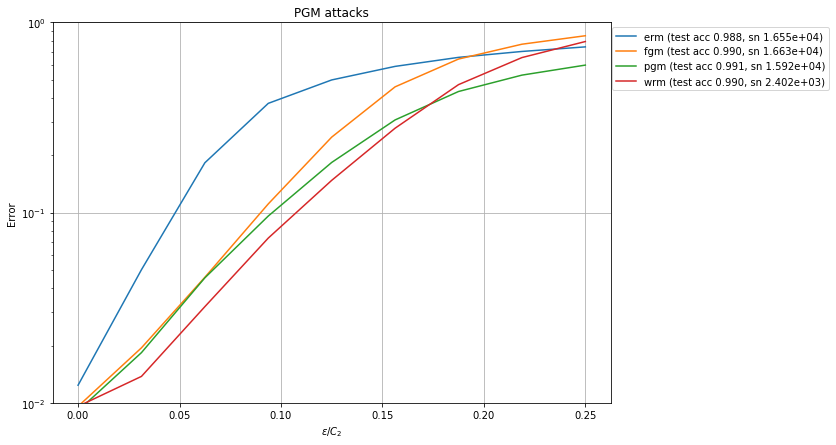

In [10]:
# Evaluate robustness of networks
eps_list = np.linspace(0, 0.25, 9)*C2

adv_results_pgm = {}
for method in methods:
    save_dir = os.path.join('save_weights_final', 'mnist', method)
    s_norm = dl_utils.get_overall_sn(save_dir, arch, num_channels=1, load_epoch=25)
    acc, adv_accs = get_adv_acc_curve(Xtt, Ytt, save_dir, arch, eps_list, order=2, method=ad.pgm, beta=1.)
    adv_results_pgm[method] = (acc, adv_accs, s_norm)
    
plot_acc_curves(adv_results_pgm, eps_list/C2)

INFO:tensorflow:Restoring parameters from save_weights_final/mnist/erm/checkpoints/epoch25
INFO:tensorflow:Restoring parameters from save_weights_final/mnist/erm/checkpoints/epoch25
INFO:tensorflow:Restoring parameters from save_weights_final/mnist/fgm/checkpoints/epoch25
INFO:tensorflow:Restoring parameters from save_weights_final/mnist/fgm/checkpoints/epoch25
INFO:tensorflow:Restoring parameters from save_weights_final/mnist/pgm/checkpoints/epoch25
INFO:tensorflow:Restoring parameters from save_weights_final/mnist/pgm/checkpoints/epoch25
INFO:tensorflow:Restoring parameters from save_weights_final/mnist/wrm/checkpoints/epoch25
INFO:tensorflow:Restoring parameters from save_weights_final/mnist/wrm/checkpoints/epoch25


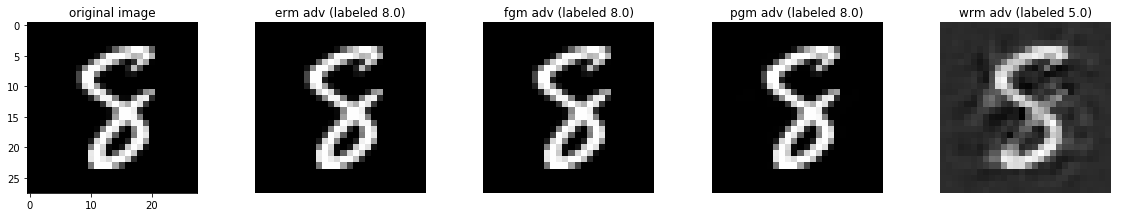

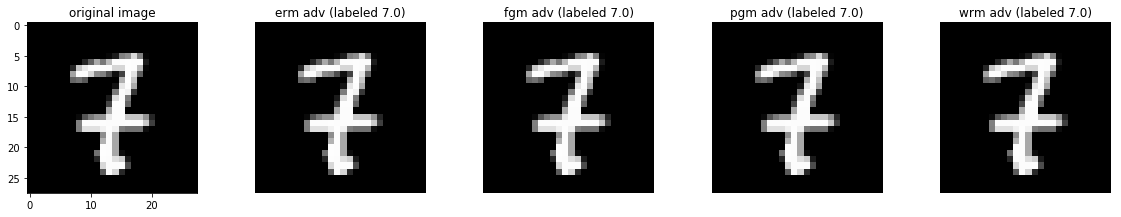

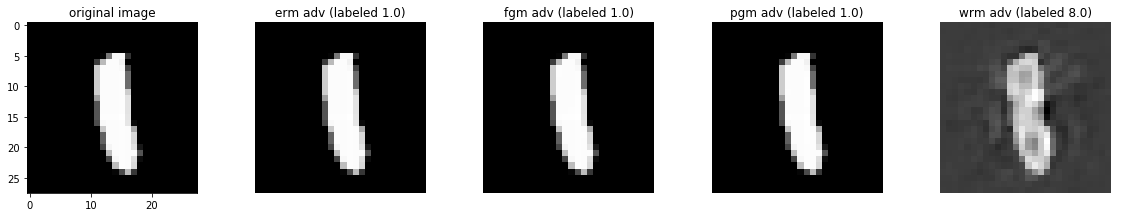

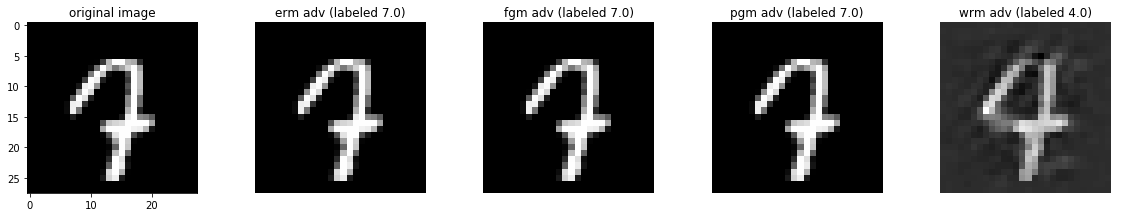

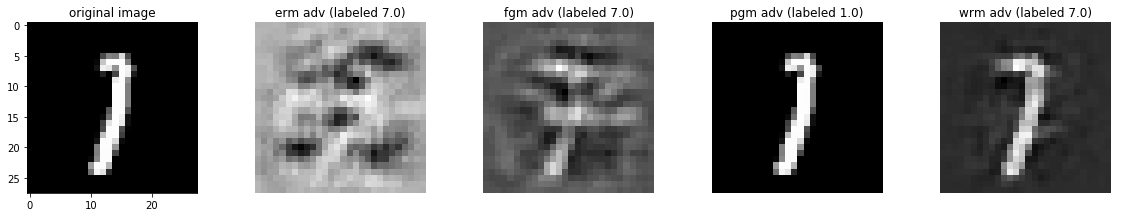

In [17]:
# Taking a closer look at some images after adversarial perturbation
eps = 0.1*C2

n = 5
np.random.seed(0)
ind_samp = np.random.choice(range(len(Xtt)), n, replace=False)
Xtt_samp = Xtt[ind_samp]

adv_examples = {}
for method in methods:
    save_dir = os.path.join('save_weights_final', 'mnist', method)
    X_adv = ad.build_graph_and_gen_adv_examples(Xtt_samp, arch, save_dir, num_channels=1,
                                                method=ad.wrm, eps=eps, order=2, load_epoch=25)
    Y_adv = dl_utils.build_graph_and_predict(X_adv, save_dir, arch, beta=1., num_channels=1, load_epoch=25)
    adv_examples[method] = (X_adv, Y_adv)
    
for i in range(n):
    plt.figure(figsize=(16, 3))
    plt.subplot(1, 5, 1)
    plt.imshow(Xtt_samp[i].reshape(28, 28), cmap='gray')
    plt.title('original image')
    for ii, method in enumerate(methods):
        plt.subplot(1, 5, ii+2)
        plt.imshow(adv_examples[method][0][i].reshape(28, 28), cmap='gray')
        plt.axis('off')
        plt.title('%s adv (labeled %s)'%(method, adv_examples[method][1][i]))
    plt.tight_layout()
    plt.show()

# Testing spectral normalization

In [8]:
def beta_sweep_curves(adv, eps_list, load_epoch=25):

    adv_results = {}
    for f in sorted(os.listdir('save_weights_final/mnist/')):
        if adv in f and 'rand' not in f:
            save_dir = os.path.join('save_weights_final', 'mnist', f)
            if 'beta' in f:
                arch = model.elunet_sn
                beta = float(f.split('beta')[1])
            else:
                arch = model.elunet
                beta = 1.
            acc, adv_accs = get_adv_acc_curve(Xtt, Ytt, save_dir, arch, eps_list, order=2,
                                              method=ad.pgm, beta=beta, load_epoch=load_epoch)
            adv_results[f] = (acc, adv_accs)
            
    return adv_results

def sort_func(f):
    if 'beta' not in f:
        return 0
    return float(f.split('beta')[1].split('_')[0])

eps_list = np.linspace(0, 0.25, 9)*C2
methods = ['erm', 'fgm', 'pgm', 'wrm']

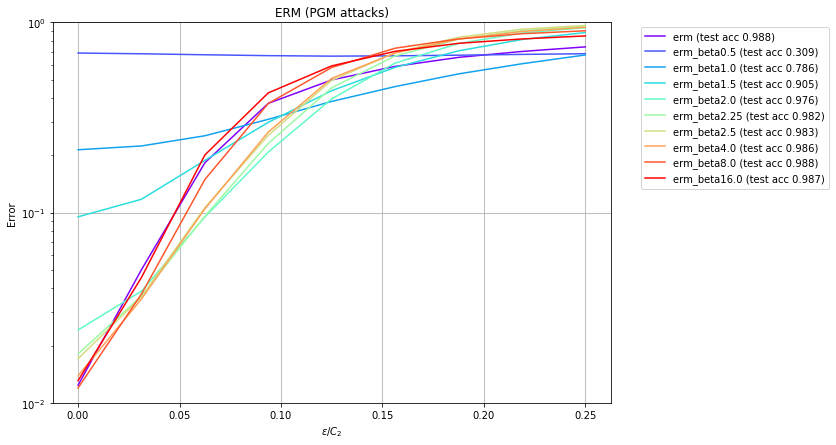

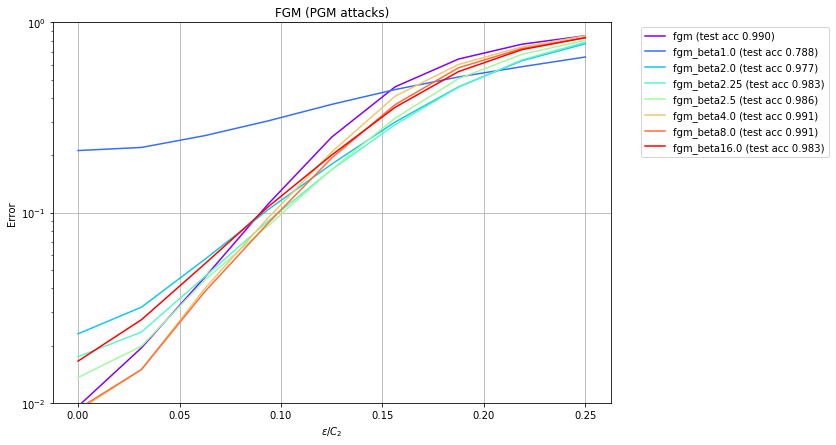

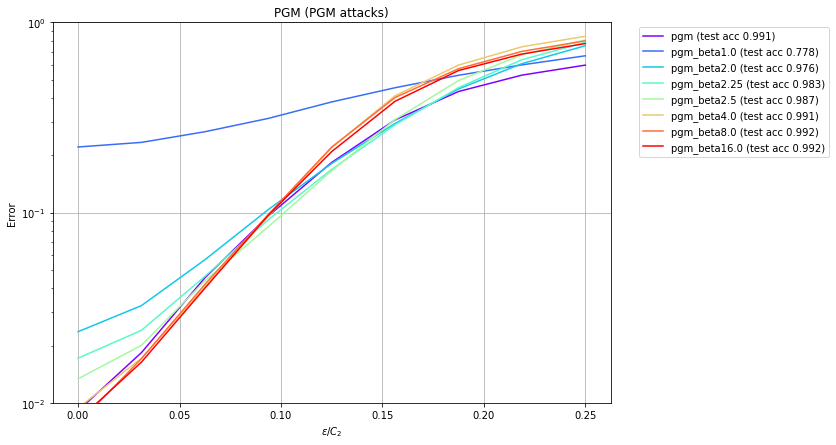

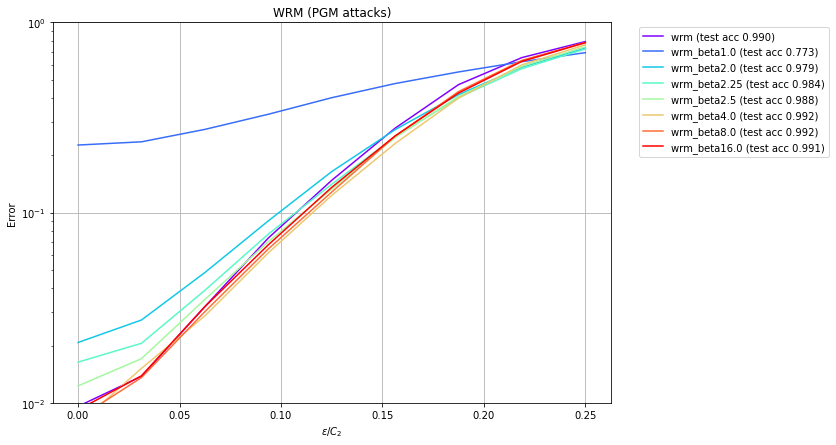

In [29]:
curves_file = 'save_weights_final/mnist/beta_adv_sweep_curves_loadepoch25.pickle'

if os.path.isfile(curves_file):
    all_beta_curves = pickle.load(file(curves_file, 'rb'))
else:
    all_beta_curves = {}
    for method in methods:
        all_beta_curves[method] = beta_sweep_curves(method, eps_list, load_epoch=25)
    pickle.dump(all_beta_curves, file(curves_file, 'wb'))

for method in methods:
    plot_acc_curves(all_beta_curves[method], eps_list/C2,
                    title='%s (PGM attacks)'%(method.upper()), sort_func=sort_func)

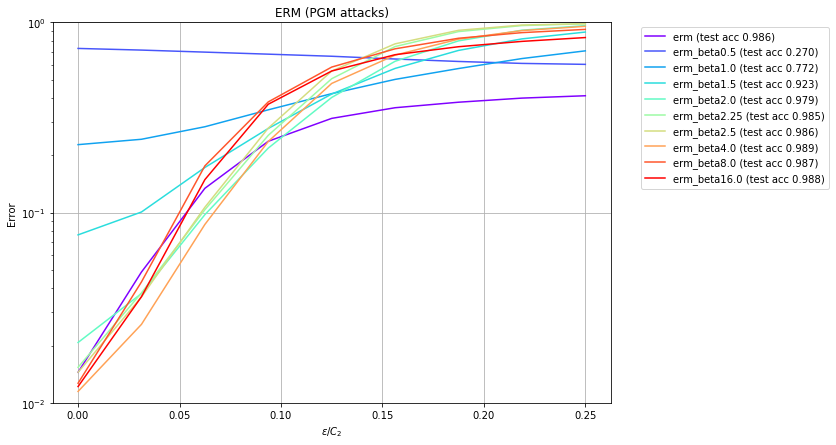

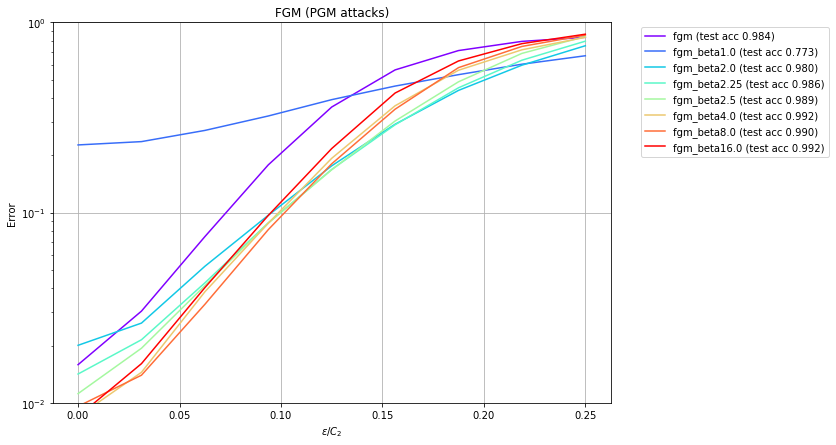

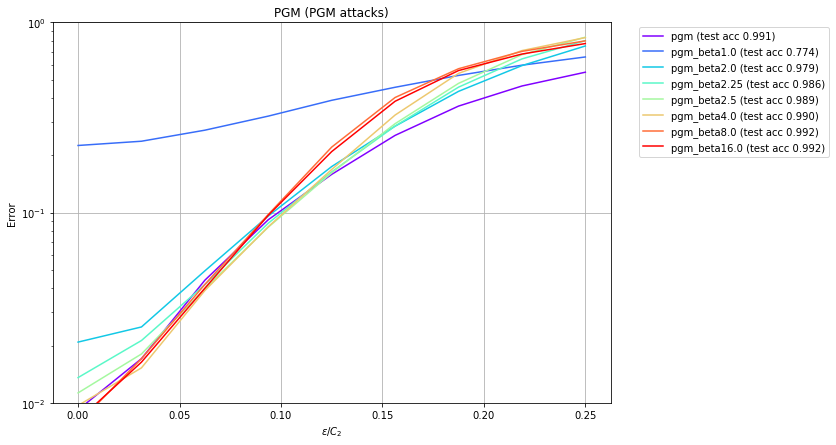

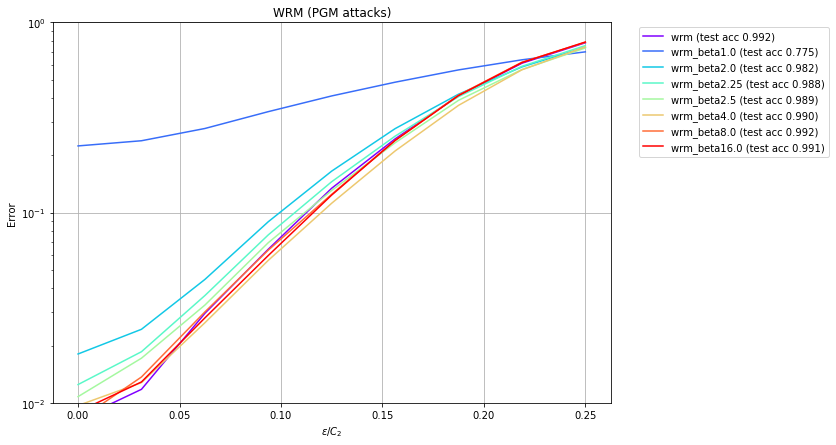

In [30]:
curves_file = 'save_weights_final/mnist/beta_adv_sweep_curves_loadepoch50.pickle'

if os.path.isfile(curves_file):
    all_beta_curves = pickle.load(file(curves_file, 'rb'))
else:
    all_beta_curves = {}
    for method in methods:
        all_beta_curves[method] = beta_sweep_curves(method, eps_list, load_epoch=50)
    pickle.dump(all_beta_curves, file(curves_file, 'wb'))

for method in methods:
    plot_acc_curves(all_beta_curves[method], eps_list/C2,
                    title='%s (PGM attacks)'%(method.upper()), sort_func=sort_func)